In [2]:
import sys
sys.path.append('../src/')
import numpy as np
import loss_function
import matplotlib.pyplot as plt
import h5py
import pandas as pd


In [12]:
with h5py.File("model_data/t_U_V_5_r5.0.hdf5",'r') as f:
    distance = f['distance'][()]
    U = f['rdmd_params/U'][()]
    V = f['rdmd_params/V'][()]
    t = f['rdmd_params/t'][()]
    test_indices = f['state_ind_for_test'][()]


ai_df = pd.read_csv("ai_data/r5.0.csv")
ai_df = ai_df[ai_df.E0 > 3.7]
#ai_df = ai_df[ai_df.U < 1.3]  # Need to remove the top two states from the optimization
ai_df = ai_df[ai_df.state < 20]
ai_df = ai_df.reset_index()
print("ai_df", ai_df)

onebody = {}
onebody_keys = []
twobody = {}
twobody_keys = []
with h5py.File("symmetric_operators.hdf5", "r") as f:
    for k in f["onebody"].keys():
        onebody[k] = f[f"onebody/{k}"][()]
        onebody_keys.append(k)
    for k in f["twobody"].keys():
        twobody[k] = f[f"twobody/{k}"][:]
        twobody_keys.append(k)

norm = 2 * np.var(ai_df)

data = loss_function.CV_evaluate_loss(params = [t,U,V],
                                      keys = ['t','U','V'],
                                      weights = [0.7,0.3],
                                      onebody = onebody,
                                      twobody = twobody,
                                      ai_df = ai_df,
                                      max_ai_energy=np.max(ai_df.energy),
                                      nroots = 36,
                                      matches = ['t','U','V'],
                                      fcivec = None,
                                      train_states = np.delete(np.arange(0, len(ai_df)), test_indices),
                                      test_states = test_indices,
                                      norm = norm,
                                      )


ai_df     index    energy  state        E0         t     tdiag         J    J_diag  \
0       0 -2.007725      0  3.904663  1.461409  0.004362  1.159077 -3.112923   
1       1 -2.003686      1  3.904174  1.064904  0.002955 -0.108044 -3.736872   
2       2 -1.998804      2  3.902542  0.540748  0.059136 -3.754717  1.831261   
3       3 -1.998680      3  3.902400  0.516402  0.032589 -3.790141 -0.034135   
4       4 -1.998680      4  3.902400  0.516401  0.032589 -3.790141 -0.034134   
5       5 -1.993953      5  3.900992  0.008812  0.000944 -5.074045 -2.536362   
6       6 -1.744517      6  3.867590  3.153867  0.099754 -1.634265 -1.184505   
7       7 -1.726704      7  3.835471  1.905476 -0.056455 -3.057827 -1.590452   
8       8 -1.717062      8  3.855621  1.540342  0.427045 -3.051654 -1.629041   
9       9 -1.717062      9  3.855622  1.540302  0.427157 -3.051647 -1.629050   
10     10 -1.715494     10  3.836020  1.810921  0.223941 -1.599949 -1.128287   
11     11 -1.715494     11  3.8360

/opt/homebrew/Caskroom/miniconda/base/envs/jax/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [13]:
data.keys()

dict_keys(['train_loss', 'test_loss', 'train_sloss', 'train_dloss', 'test_sloss', 'test_dloss', 'penalty', 'descriptors', 'distance', 'row_ind', 'col_ind', 'params', 'test_rows', 'test_cols'])

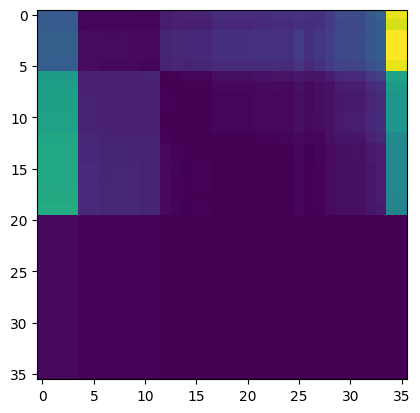

In [14]:
plt.imshow(data['distance'])

In [15]:
print(t,U,V)

-0.036579137602398254 -0.50420533376951 -0.3833369413514653


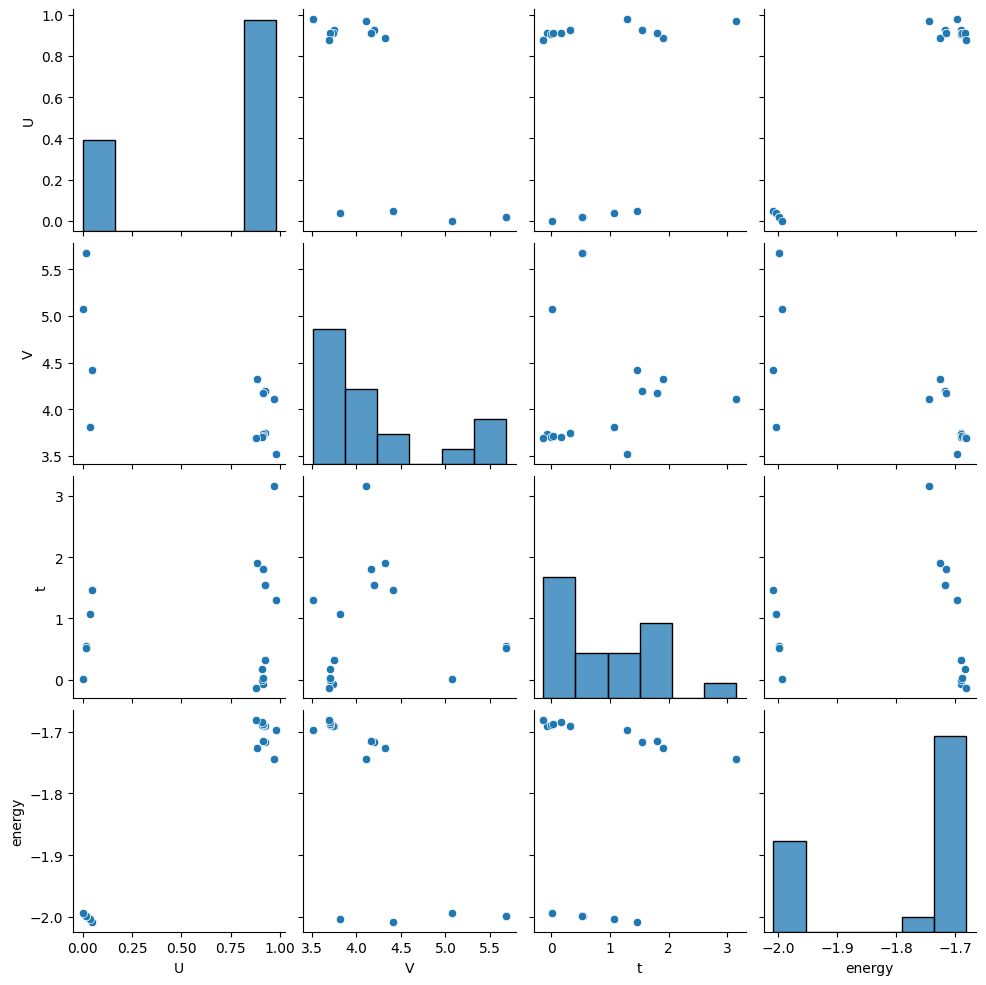

In [18]:
import seaborn as sns
sns.pairplot(ai_df[['U','V','t','energy']])

In [23]:
import statsmodels.api as sm
X = sm.add_constant(ai_df[['U','t']])
dmd = sm.OLS(ai_df["energy"], X).fit()
dmd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4949.
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           3.09e-24
Time:                        10:22:41   Log-Likelihood:                 75.082
No. Observations:                  20   AIC:                            -144.2
Df Residuals:                      17   BIC:                            -141.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9928      0.003   -719.474      0.000      -1.999      -1.987
U              0.3379      0.003     99.390      0.000       0.331       0.345
t             -0.0219      0.002    -13.619      0.000      -0.025      -0.019
==============================================================================
Omnibus:                        1.378   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.502   Jarque-Bera (JB):                1.195
Skew:                           0.528   Prob(JB):                        0.550
Kurtosis:                       2.434   Cond. No.                         4.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""